In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams['figure.dpi'] = 80

import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid", {'grid.linestyle': '--'})

In [2]:
players = pd.read_pickle('./dataset/final_players.pkl')

In [3]:
players = players[players['stats_match_count'] >= 15]

In [4]:
players['top_player'] = (players['l1_sf_match_count'] + players['l2_sf_match_count'] > 0).astype(int)

In [5]:
rank_cols = list(filter(lambda s : 'rank_sem' in s, players.columns))
players['under_50'] = ((players[rank_cols] <= 50).sum(axis=1) != 0).astype(int)

In [6]:
players.loc[(players['under_50'] == 1) & (players['top_player'] == 0), 'top_player'] = 1

In [7]:
players['top_player'].value_counts()

0    1026
1     347
Name: top_player, dtype: int64

In [8]:
players['sex'] = np.where(players['sex'] == 'm', 1, 0)

In [9]:
#input_features = ['sex', 'ace_mean', 'ace_ratio', 'df_mean', 'df_ratio', 'bp_saved_ratio', 'bp_w_ratio', 'svpt_w_ratio', 'svpt_1st_fail_ratio', 'w_ratio', 'hard_w_ratio', 'clay_w_ratio']
input_features = ['sex', 'ace_mean', 'ace_ratio', 'df_mean', 'df_ratio', 'bp_saved_ratio', 'bp_w_ratio', 'svpt_w_ratio', 'svpt_1st_fail_ratio', 'w_ratio']
#input_features = ['sex', 'w_ratio']

In [10]:
to_drop = [x for x in players.columns if x not in input_features + ['top_player']]
players = players.drop(columns=to_drop)

In [11]:
players = players.dropna()

In [12]:
players['top_player'].value_counts()

0    1026
1     347
Name: top_player, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split
label = players.pop('top_player')
train_set, test_set, train_label, test_label = train_test_split(players, label, stratify=label, test_size=0.25, random_state=13)

---

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

We will start plotting a *Decision Tree Classifier* without any parameters, in this way the value of the `max_depth` of the tree will be set to expand itself until all the leaves are pure or until they contains *less* than 2 samples.

The `max_depth` obtained by this tree will be used in the following process of *Randomized Search*.

In [15]:
# expansion until all the leaves are pure
dt_max_depth = DecisionTreeClassifier(random_state=13)
dt_max_depth = dt_max_depth.fit(train_set, train_label)

In [16]:
max_depth = dt_max_depth.get_depth()
print(max_depth)

18


In [17]:
divider = '_' * 60
def print_stats(dt, train_pred, train_label, test_pred, test_label):
    print(divider)
    print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred))
    print('Precision train set ', metrics.precision_score(train_label, train_pred, average='weighted'))
    print('Recall train set ', metrics.recall_score(train_label, train_pred, average='weighted'))
    print('F1 score train set ', metrics.f1_score(train_label, train_pred, average='weighted'))
    print(divider)
    print(classification_report(test_label, test_pred))
    print(divider)
    importance = pd.DataFrame({'feature': train_set.columns, 'importance' : np.round(dt.feature_importances_, 6)})
    importance.sort_values('importance', ascending=False, inplace = True)
    print(importance)
    print(divider)
    sns.heatmap(confusion_matrix(test_label, test_pred, normalize='true'), annot=True, cmap='Blues', fmt='g')
    plt.show()

We train the model and print some stats about it.

In [18]:
train_pred_dt = dt_max_depth.predict(train_set)
test_pred_dt = dt_max_depth.predict(test_set)

____________________________________________________________
Accuracy train set  1.0
Accuracy test set  0.7412790697674418
Precision train set  1.0
Recall train set  1.0
F1 score train set  1.0
____________________________________________________________
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       257
           1       0.49      0.52      0.50        87

    accuracy                           0.74       344
   macro avg       0.66      0.67      0.66       344
weighted avg       0.75      0.74      0.74       344

____________________________________________________________
               feature  importance
9              w_ratio    0.284744
7         svpt_w_ratio    0.159735
8  svpt_1st_fail_ratio    0.121005
6           bp_w_ratio    0.114231
5       bp_saved_ratio    0.112062
2              df_mean    0.070969
4             df_ratio    0.056971
0                  sex    0.035173
3            ace_ratio    0.028557
1      

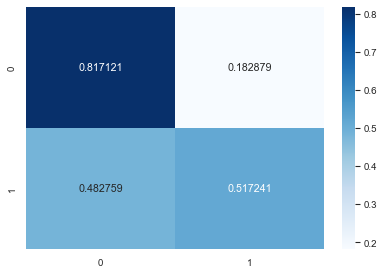

In [19]:
print_stats(dt_max_depth, train_pred_dt, train_label, test_pred_dt, test_label)

Which seems to overfit the data and gives only slightly more than the $50\%$ of prediction over the *top-ranked* players. 

## Finding the best parameters: optimizing ROC

Let's see if we can achieve something better trying to tune some hyperparameter by *Random Search*.

Some considerations:
* The dataset is highly imbalanced towards the so called *top players*, so in order to try to correct this imbalance we will add *class weights* in favour to the label $1$ and we will let the model choose if use them or not.
* Both the *entropy* and *Gini* criterion can be used.
* For the `max_depth` all the parameters between $2$ and the *max* found above will be used.
* The other parameters of interest for the `DecisionTreeClassifier` will be chosen between standard, well-known ranges. However, for some of those parameters we prefer to use a *logspace* subdivision rather than a classical linear space since, by previous tests, the model seems to prefer values nearest to the lower bound.

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

stratified_kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=13
)

max_iter = 100000 # computed value
# max_iter = 500

tuned_parameters = {
    "max_depth": list(range(2, max_depth + 1)),
    "min_samples_split": list(map(int, np.logspace(0.32, 2.48, num=max_iter))), # [2, ~300]
    "min_samples_leaf": list(map(int, np.logspace(0, 2.18, num=max_iter))), # [1, ~150]
    "criterion": ["entropy", "gini"],
    "class_weight": ['balanced', None, {0: 0.3, 1: 0.7}, {0: 0.35, 1:0.65}, {0:0.37, 1:0.63}, {0:0.4, 1:0.6}, {0:0.45, 1:0.55}, {0:0.47, 1:0.53}],
    "max_features": list(range(1, len(train_set.iloc[0]) + 1)) + ['auto', 'log2', None]
}

rs_t = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=13),
    tuned_parameters,
    scoring=scoring,
    refit="AUC",
    cv=stratified_kf,
    n_jobs=8,
    n_iter=max_iter,
    return_train_score=True,
    random_state=13
)

rs_t.fit(train_set, train_label)
results = rs_t.cv_results_

In [72]:
print('Best params:' + str(rs_t.best_params_))
print('Best score:' + str(rs_t.best_score_))

Best params:{'min_samples_split': 80, 'min_samples_leaf': 7, 'max_features': 4, 'max_depth': 18, 'criterion': 'gini', 'class_weight': {0: 0.4, 1: 0.6}}
Best score:0.8249804933628463


We have found a (reasonably) best combination of parameters <u>according to the *AUC* score</u>.

However, we prefer to compare the combinations found <u>not only by the *AUC* score</u> but also taking into consideration the *mean accuracy* found over the test set.


In [25]:
results_dt = pd.DataFrame(rs_t.cv_results_)

In [42]:
results_dt[['mean_test_Accuracy', 'mean_test_AUC']].sort_values('mean_test_AUC', ascending=False).head(10)

,mean_test_Accuracy,mean_test_AUC
41100,0.766810,0.824980
42943,0.786214,0.819887
71767,0.786214,0.819887
31474,0.786214,0.819887
78901,0.759010,0.819343
69313,0.774587,0.819195
21110,0.728852,0.819153
21321,0.728852,0.819153
57443,0.728852,0.819103
92603,0.737637,0.818955


In [26]:
results_dt.loc[results['mean_test_AUC'] > 0.80, ['mean_test_Accuracy', 'mean_test_AUC']].sort_values('mean_test_Accuracy', ascending=False).head(10)

,mean_test_Accuracy,mean_test_AUC
74121,0.795927,0.809381
32396,0.795927,0.809381
62317,0.794975,0.811707
37640,0.794975,0.811707
8872,0.793995,0.815612
68166,0.793995,0.815612
46431,0.793966,0.801673
87992,0.793014,0.808320
35559,0.793014,0.808320
75265,0.793005,0.803039


As we can see above, the best parameters found (index $41100$) does not behave in the same way when speaking about accuracy, since it doesn't occur in the *first ten* accuracies found neither.

A better tradeoff between the two measures is given by the index $42943$ which loses a very small portion against the *best* found but gains about a $.02$ in terms of accuracy.

In [142]:
# tree_opt = rs_t.best_estimator_
tree_opt = DecisionTreeClassifier(random_state=13, **(results_dt.loc[42943, 'params']))
pipe_dt = tree_opt.fit(train_set, train_label)
train_pred_opt = tree_opt.predict(train_set)
test_pred_opt = tree_opt.predict(test_set)

____________________________________________________________
Accuracy train set  0.793974732750243
Accuracy test set  0.8081395348837209
Precision train set  0.8153936658043356
Recall train set  0.793974732750243
F1 score train set  0.8011225481446222
____________________________________________________________
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       257
           1       0.60      0.72      0.66        87

    accuracy                           0.81       344
   macro avg       0.75      0.78      0.76       344
weighted avg       0.82      0.81      0.81       344

____________________________________________________________
               feature  importance
9              w_ratio    0.350091
7         svpt_w_ratio    0.315107
5       bp_saved_ratio    0.188824
0                  sex    0.145979
1             ace_mean    0.000000
2              df_mean    0.000000
3            ace_ratio    0.000000
4             df_ra

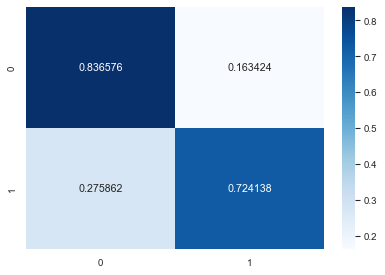

In [153]:
print_stats(tree_opt, train_pred_opt, train_label, test_pred_opt, test_label)

We have *definitely* improved against our original model.

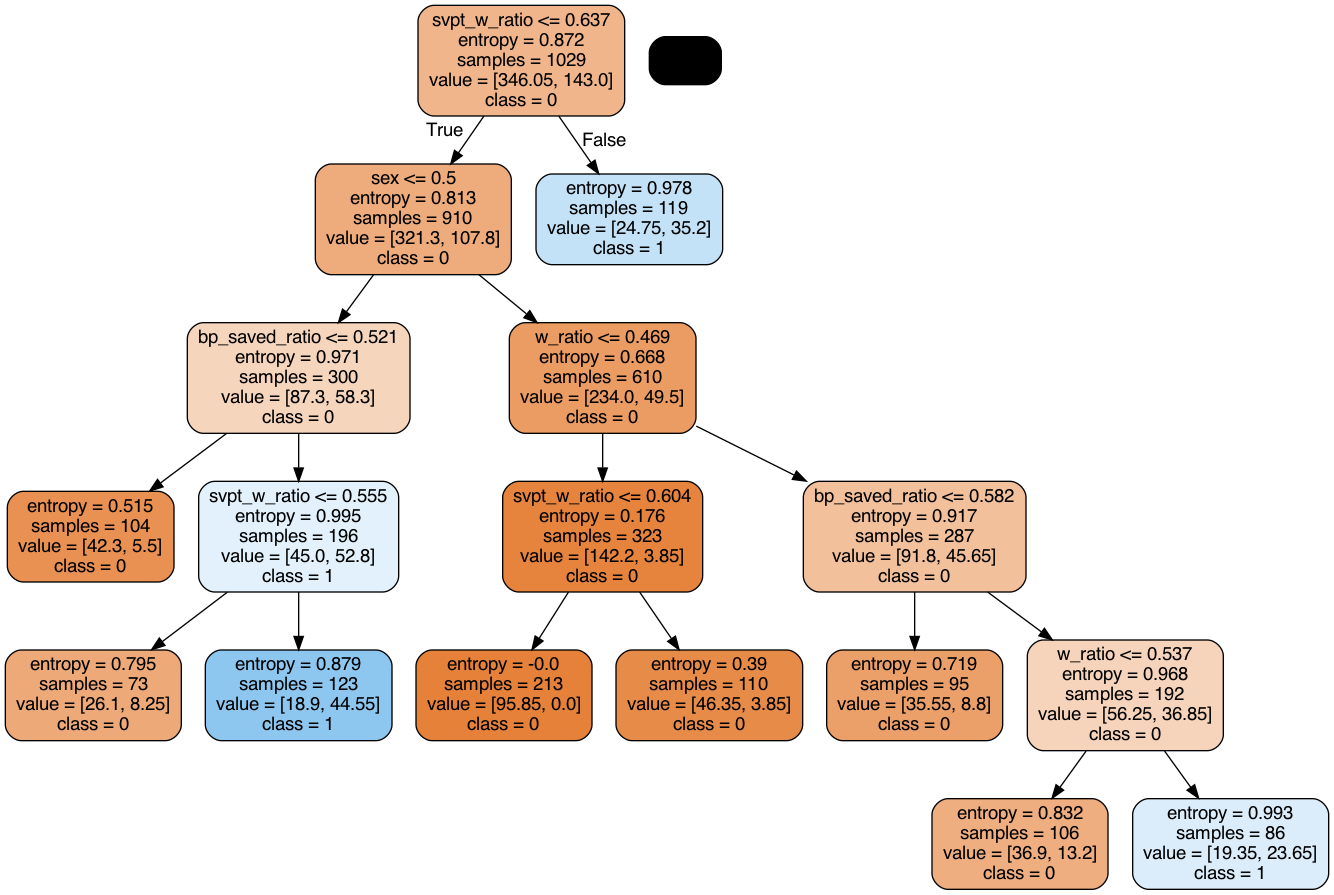

In [47]:
from sklearn.tree import export_graphviz
import pydotplus 
from IPython.display import Image  
dot_data = export_graphviz(tree_opt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['0', '1'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

---

# Random Forest Classifier

The following model that we will try is the *Random Forest* ensemble classifier.

Again, we will start plotting a *no parameters* model, unfortunately this time we can't exploit the `max_depth` of the tree.

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=13)
rf.fit(train_set, train_label)

RandomForestClassifier(random_state=13)

In [31]:
train_pred_rf = rf.predict(train_set)
test_pred_rf = rf.predict(test_set)

____________________________________________________________
Accuracy train set  1.0
Accuracy test set  0.8401162790697675
Precision train set  1.0
Recall train set  1.0
F1 score train set  1.0
____________________________________________________________
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       257
           1       0.74      0.56      0.64        87

    accuracy                           0.84       344
   macro avg       0.80      0.75      0.77       344
weighted avg       0.83      0.84      0.83       344

____________________________________________________________
               feature  importance
9              w_ratio    0.221861
7         svpt_w_ratio    0.140222
5       bp_saved_ratio    0.113221
6           bp_w_ratio    0.098308
8  svpt_1st_fail_ratio    0.095965
3            ace_ratio    0.077492
4             df_ratio    0.075260
1             ace_mean    0.073978
2              df_mean    0.070761
0      

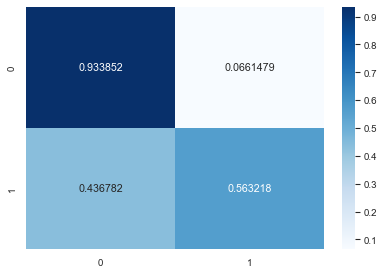

In [32]:
print_stats(rf, train_pred_rf, train_label, test_pred_rf, test_label)

We have already reached a better accuracy over the entire test set than the best decision tree classifier found, at the expenses of the accuracy over the prediction of the label $1$. However, the prediction over the label $0$ is convincing. Furthermore, the model seems to overfit the data.

## Randomized Search over the Random Forest

Again, we try to find a valid set of parameters through *Randomized Search*. We recall the same considerations for the parameters done when searching for the *Decision Tree*, optimizing them for the current context. 

In [88]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

stratified_kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=13
)

# max_iter = 500 # computed value
# max_iter = 30

max_iter = 500
tuned_parameters = {
    "n_estimators": sp_randint(200, 2000),
    "max_depth": list(range(2, 102, 10)) + [None],
    "min_samples_split": list(map(int, np.logspace(0.32, 2.48, num=max_iter))), # [2, ~300]
    "min_samples_leaf": list(map(int, np.logspace(0, 2.18, num=max_iter))), # [1, ~150]
    "criterion": ["entropy", "gini"],
    "class_weight": ['balanced', None, {0: 0.3, 1: 0.7}, {0: 0.35, 1:0.65}, {0:0.37, 1:0.63}, {0:0.4, 1:0.6}, {0:0.45, 1:0.55}, {0:0.47, 1:0.53}],
    "max_features": list(range(4, len(train_set.iloc[0]) + 1)) + ['auto', 'log2', None],
    "bootstrap": [True, False]
} 

rs_f = RandomizedSearchCV(
    RandomForestClassifier(random_state=13),
    tuned_parameters,
    scoring=scoring,
    refit="AUC",
    cv=stratified_kf,
    n_jobs=8,
    n_iter=max_iter,
    return_train_score=True,
    random_state=13
)

rs_f.fit(train_set, train_label)
results = rs_f.cv_results_

In [132]:
print('Best params: ' + str(rs_f.best_params_))
print('Best score: ' + str(rs_f.best_score_))

Best params: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 92, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 1095}
Best score: 0.8556499056499056


Again, even if we found the best optimization for the *AUC* metric, we want to find a good tradeoff also against the standard *accuracy*.

In [125]:
results_rf_opt = pd.DataFrame(rs_f.cv_results_)

In [126]:
results_rf_opt[['mean_test_Accuracy', 'mean_test_AUC']].sort_values('mean_test_AUC', ascending=False).head(10)

,mean_test_Accuracy,mean_test_AUC
469,0.808572,0.855650
93,0.810519,0.853874
328,0.809538,0.852848
448,0.808582,0.852023
357,0.809543,0.851826
202,0.807601,0.851575
48,0.804684,0.851549
333,0.806640,0.850702
498,0.779375,0.850666
83,0.809548,0.850230


In [127]:
results_rf_opt.loc[results['mean_test_AUC'] > 0.84, ['mean_test_Accuracy', 'mean_test_AUC']].sort_values('mean_test_Accuracy', ascending=False).head(10)

,mean_test_Accuracy,mean_test_AUC
277,0.823164,0.848562
24,0.820242,0.849513
424,0.820242,0.846612
249,0.820237,0.845367
269,0.820232,0.842974
164,0.818295,0.842640
418,0.818276,0.843239
362,0.817315,0.841637
237,0.816353,0.845464
153,0.816344,0.842690


We prefer the model with index `94` which seems to provide a better tradeoff.

In [137]:
rf_opt = RandomForestClassifier(random_state=13, **(results_rf_opt.loc[93, 'params']))
pipe_rf = rf_opt.fit(train_set, train_label)

In [129]:
train_pred_rf_opt = rf_opt.predict(train_set)
test_pred_rf_opt = rf_opt.predict(test_set)

____________________________________________________________
Accuracy train set  0.93488824101069
Accuracy test set  0.8372093023255814
Precision train set  0.935351181440104
Recall train set  0.93488824101069
F1 score train set  0.9350921134458816
____________________________________________________________
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       257
           1       0.69      0.66      0.67        87

    accuracy                           0.84       344
   macro avg       0.79      0.78      0.78       344
weighted avg       0.83      0.84      0.84       344

____________________________________________________________
               feature  importance
9              w_ratio    0.298627
7         svpt_w_ratio    0.141128
5       bp_saved_ratio    0.122108
6           bp_w_ratio    0.098540
8  svpt_1st_fail_ratio    0.071854
1             ace_mean    0.060589
3            ace_ratio    0.058451
4             df_ratio

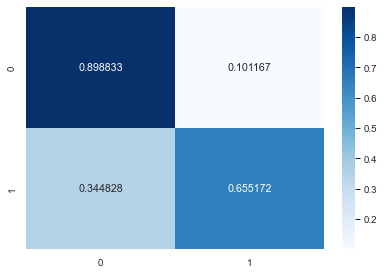

In [154]:
print_stats(rf_opt, train_pred_rf_opt, train_label, test_pred_rf_opt, test_label)

The model shows a better overall accuracy than the *Decision Tree* optimal classifier, however losing something when predicting the label $1$.

---

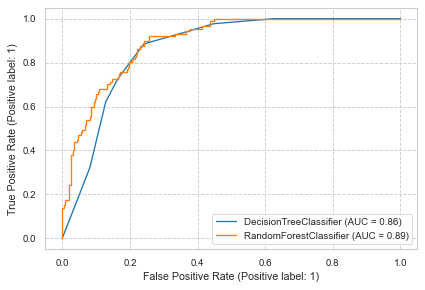

In [157]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
RocCurveDisplay.from_estimator(tree_opt, test_set, test_label, ax=ax)
RocCurveDisplay.from_estimator(rf_opt, test_set, test_label, ax=ax)
plt.show()

---

In [155]:
import pickle

with open('decision_tree.pickle', 'wb') as handle:
    pickle.dump(tree_opt, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('random_forest.pickle', 'wb') as handle:
    pickle.dump(rf_opt, handle, protocol=pickle.HIGHEST_PROTOCOL)
